In [1]:
from IPython import get_ipython
ipython = get_ipython()
if ipython is not None:
    ipython.run_line_magic('load_ext', 'autoreload')
    ipython.run_line_magic('autoreload', '2')
else:
    print("could not load extension")

%reload_ext autoreload

In [2]:
import getpass

user = getpass.getuser()
from omni.isaac.kit import SimulationApp

# Set the path below to your desired nucleus server
# Make sure you installed a local nucleus server before this
# and that isaacsim is running
simulation_app = SimulationApp({"livesync_usd": f"omniverse://localhost/Users/{user}/telecom_test.usd"})

[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] =========================== DEPRECATION WARNING ===========================
[Warning] [omni.isaac.kit] 
[Warning] [omni.isaac.kit] Traceback (most recent call last):
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/share/ov/pkg/isaac-sim-4.2.0/kit/python/lib/python3.10/runpy.py', line 196
[Warning] [omni.isaac.kit]   return _run_code(code, main_globals, None,
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/share/ov/pkg/isaac-sim-4.2.0/kit/python/lib/python3.10/runpy.py', line 86
[Warning] [omni.isaac.kit]   exec(code, run_globals)
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python3.10/site-packages/ipykernel_launcher.py', line 18
[Warning] [omni.isaac.kit]   app.launch_new_instance()
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python3.10/site-packages/traitlets/config/application.py', line 1075
[Warning] [omni.isaac.kit]   app.start()
[Warning] [omni.isaac.kit] File '/home/ubuntu/.local/lib/python

2025-03-04 21:21:20 [12,591ms] [Error] [gpu.foundation.plugin] Failed to read texture file ./textures/color_121212.hdr or file is empty
2025-03-04 21:21:20 [12,591ms] [Error] [rtx.scenedb.plugin] Failed to upload DomeLight texture ./textures/color_121212.hdr


[12.815s] app ready


In [ ]:
import carb
from omni.physx import get_physx_scene_query_interface  # for raycasting e.g raycast_closest()
import omni.physx.scripts.utils as physx_utils
from omni.isaac.core import World
from omni.isaac.core.objects import DynamicCuboid, DynamicSphere, DynamicCone, DynamicCylinder
from omni.timeline import get_timeline_interface
from omni.isaac.core.utils.stage import get_current_stage
import omni.isaac.core.utils.prims as prims_utils
from omni.isaac.core.utils.stage import get_current_stage
import omni.kit.commands

import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
from math import pi as PI
from scipy.constants import c as C # speed of light

In [4]:
from omni.syntheticdata import visualize
from omni.kit.viewport.utility import get_active_viewport
import omni.replicator.core as rep
from omni.isaac.core.utils.viewports import set_camera_view


set_camera_view(eye=np.array([0, 0, 10]), target=np.array([0, 0, 0]))

viewport_api = get_active_viewport()
active_cam = viewport_api.get_active_camera()

viewport_api.set_texture_resolution([1000, 1000])
resolution = viewport_api.get_texture_resolution()
render_product = rep.create.render_product(active_cam, resolution)

In [5]:
rgb = rep.AnnotatorRegistry.get_annotator("rgb")
rgb.attach([render_product])
depth = rep.AnnotatorRegistry.get_annotator("distance_to_image_plane")
depth.attach([render_product])
semantic_segmentation = rep.AnnotatorRegistry.get_annotator("semantic_segmentation")
semantic_segmentation.attach([render_product])

# Antenna class

In [ ]:
#..........G = the gain of the antenna (its maximum gain)
#..........e = its efficiency
# waveLength = the wavelength for which it emits/receives
#.......mode = 1 if emitter, 0 if receiver
# theta, phi = angles defining the direction it emits/receives
#........pow = receivable power
class Antenna(DynamicCylinder):
    def __init__(self, prim_path, name, waveLength, G, e, position=None, orientation=None, scale=None, color=None, radius=None, height=None, mode=0, pow=0):
        super().__init__(prim_path=prim_path, name=name, position=position, orientation=orientation, scale=scale, color=color, radius=radius, height=height)
        self.waveLength = waveLength
        self.G = G
        self.e = e
        self.L = waveLength/2
        self.frequency = C/self.waveLength
        self.directivity = G/e
        self.mode = mode
        self.theta = 0
        self.phi = 0
        self.pow = 0
    
    def getLength(self):
        return self.L
    
    def getGain(self):
        return self.G
    
    def getFrequency(self):
        return self.frequency
    
    def getDirectivity(self):
        return self.directivity
    
    def getPower(self):
        return self.pow
    
    def setMode(self, mode):
        if mode == 0 or mode == 1:
            self.mode = mode
        else:
            raise ValueError("The mode must be 0 (emitter) or 1 (receiver).")
    
    def setDirection(self, theta, phi):
        if 0 > theta or theta > PI:
            raise ValueError("Theta must have a value between 0 and pi.")
        if 0 > phi or phi > 2*PI:
            raise ValueError("Phi must have a value between 0 and 2*pi.")
        self.theta = theta
        self.phi = phi
        
    def setPower(self, power):
        if 0 > power :
            raise ValueError("Antenna receivable power must be larger than 0")
        self.pow = power

In [ ]:
from pxr import UsdGeom, Gf, Vt

# IN :
#  - stage : the stage of the scene (obtained using get_current_stage)
#  - object1 : the object emitting the ray
#  - object2 : the object receiving the ray
#  - increment : the distance the beginning of the ray should be moved
# OUT :
#  - the "file"-path of the ray cast. If object2 has not been hit, is equalt to None by default.
#  - the distance covered by the ray before it hit an obstacle. If object2 has not been hit, is equal to 10000 by default.
def performRaycast(stage, object1, object2, distance_increment):
    
    object1_position = moveOriginRaycast(object1, object2, distance_increment)
    object2_position,_ = object2.get_world_pose()
    
    # Calculate direction from object1 to object2
    direction = (object2_position[0] - object1_position[0], 
                 object2_position[1] - object1_position[1], 
                 object2_position[2] - object1_position[2])
    
    # Normalize the direction vector
    distance = np.linalg.norm(direction)
    direction_normalized = tuple(d / distance for d in direction)

    # Origin of the ray (from object1)
    #origin = carb.Float3(object1_position[0], object1_position[1], object1_position[2])
    rayDir = carb.Float3(direction_normalized[0], direction_normalized[1], direction_normalized[2])
    
    # Perform the raycast and check for a hit
    hit = get_physx_scene_query_interface().raycast_closest(object1_position, rayDir, distance)

    if hit["hit"]:
        usdGeom = UsdGeom.Mesh.Get(stage, hit["rigidBody"])
        objects_distance = hit["distance"]

        # hitColor = Vt.Vec3fArray([Gf.Vec3f(1., 1., 0.0)])
        # usdGeom.GetDisplayColorAttr().Set(hitColor)
        # world.render()
        return usdGeom.GetPath().pathString, objects_distance

    # No hit, return None and a large distance value
    return None, 10000.0

# IN : 
#  - object1 : the object emitting the ray
#  - object2 : the object receiving the ray
#  - increment : the distance the beginning of the ray should be moved
# OUT :
#  the new origin of the ray
def moveOriginRaycast(object1, object2, increment):

    object1_position,_ = object1.get_world_pose()
    object2_position,_ = object2.get_world_pose()
    
    direction = (object2_position[0] - object1_position[0], 
                 object2_position[1] - object1_position[1], 
                 object2_position[2] - object1_position[2])
    origin = np.array(object1_position)

    direction_normalized = direction / np.linalg.norm(direction)

    new_origin = origin + direction_normalized * increment
    
    return tuple(new_origin)

def checkRaycastCoherence(output_ray, path2):
    path1 = output_ray[0]

    if path1 is None or path2 is None:
        return 0
    
    object_name1 = path1.split('/')[-1]
    object_name2 = path2.split('/')[-1]

    if object_name2 == object_name1:
        return 1
    else:
        return 0

def displayRaycastCoherence(output_ray, path2):
    if checkRaycastCoherence(output_ray, path2):
        print("The signal has been received.")
    else:
        print("The signal has not been received.")

In [ ]:
def power_losses(distance):
    if distance == 0:
        return 0
    else:
        return 1/distance**2

def checkPowerFeasibility(distance, minimum_power):
    if power_losses(distance) >= minimum_power:
        return 1
    else:
        return 0

def displayPowerFeasibility(distance, minimum_power):
    if checkPowerFeasibility(distance, minimum_power):
        print("The signal is detectable by the receiver.")
    else:
        print("The signal is not detectable by the receiver.")

# Setup Test World Programatically


## Position of the Sun

In [ ]:
from omni.isaac.core.utils.stage import get_current_stage
stage = get_current_stage()

def adjust_light(stage, position):
    lights = []
    for prim in stage.Traverse():
        if prim.GetTypeName() == "SphereLight":
            lights.append(prim)
    if lights:
        light = lights[0]
        light_path = light.GetPath()
        # Adjust position
        translate_attr = stage.GetPrimAtPath(light_path).GetAttribute("xformOp:translate")
        translate_attr.Set(position)
        # Adjust intensity
        intensity_attr = stage.GetPrimAtPath(light_path).GetAttribute("intensity")
        intensity_attr.Set(3e6)

In [ ]:
sun_coord = (5, -5, 5)
adjust_light(stage, sun_coord)
world.render()


###############################

# Run the application for multiple frames to ensure the synthetic data pipeline is initialized
timeline = get_timeline_interface()
timeline.play()
for _ in range(10):
    simulation_app.update()
timeline.pause()

# Get groundtruth
rgb_data = rgb.get_data()
depth_data = depth.get_data()
semantic_segmentation_data = semantic_segmentation.get_data()

###############################

# Initialize grid with proper resolution
cell_size = 0.025  # meters
grid_size = int(10 / cell_size)   # e.g 100x100 grid for 0.1 cell size in a 10x10 area
half_side_size = grid_size/2*cell_size 
grid_size ** 2

## Case 1: Simple flat environment + dummy objects

In [96]:
world = World(stage_units_in_meters=1.0)
world.clear()
world.scene.add_default_ground_plane()
# A render/ step or an update call is needed to reflect the changes to the opened USD in Isaac Sim GUI
#  Note: avoid pressing play / pause or stop in the GUI in this workflow.
world.render()

In [97]:
fancy_cube = world.scene.add(
    DynamicCuboid(
        prim_path="/World/random_cube",
        name="fancy_cube",
        position=np.array([0, 0, 1]),
        scale=np.array([1, 1, 1]),
        size=1.,
        color=np.array([0, 0, 1]),
    )
)

fancy_sphere = world.scene.add(
    DynamicSphere(
        prim_path="/World/random_sphere",
        name="fancy_sphere",
        position=np.array([2, 0, 1]),
        radius=1.,
        color=np.array([0, 1, 0]),
    )
)

fancy_cone = world.scene.add(
    DynamicCone(
        prim_path="/World/random_cone",
        name="fancy_cone",
        position=np.array([-2.5, -0.2, 1]),
        height=2.,
        radius=1.,
        color=np.array([1, 0, 0]),
    )
)

world.render()

In [ ]:
pointingObjectPath = fancy_cone.prim_path
origin = moveOriginRaycast(fancy_sphere, fancy_cone, 1.)

stage = get_current_stage()
out_raycast = performRaycast(stage, fancy_sphere, fancy_cone, origin)
print(out_raycast)

displayRaycastCoherence(out_raycast, pointingObjectPath)

(None, 10000.0)
The signal has not been received.


## Case 2: Lunar environment + two antennas

In [107]:
world = World(stage_units_in_meters=1.0)
world.clear()

In [108]:
usd_path = f"omniverse://localhost/Users/ubuntu/moon_environnement.usd"
prim_path = "/World/Lunar_Base"

ground_path = prim_path + "/Ground"
# create the prim
prim_ground = prims_utils.create_prim(prim_path=ground_path, usd_path=usd_path)
world.render()

2025-03-05 12:17:57 [53,810,076ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 12:17:57 [53,810,076ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 12:17:57 [53,810,076ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 12:17:57 [53,810,076ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 12:17:57 [53,810,076ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '



2025-03-05 12:17:59 [53,811,471ms] [Error] [rtx.scenedb.plugin] Failed to upload DomeLight texture ./textures/color_121212.hdr


In [109]:
### Creation of the first antenna, with a gain = 10dB, a waveLength = 1e-3m, an efficiency = 1

antenna1 = world.scene.add(
    Antenna(
        prim_path="/World/antenna1",
        name="antenna1",
        waveLength = 1e-3,
        G = 10,
        e = 1,
        position=np.array([12,-21,23]),
        scale=np.array([0.1,0.1,4]),
        height=1.0,
        color=np.array([0.0,1.0,0.0]),
    )
)
world.render()

In [110]:
### Creation of the second antenna, with the same properties as the first one

antenna2 = world.scene.add(
    Antenna(
        prim_path="/World/antenna2",
        name="antenna2",
        waveLength = 1e-3,
        G = 10,
        e = 1,
        position=np.array([-56,9,21]),
        scale=np.array([0.1,0.1,4]),
        height=1.0,
        color=np.array([1.0,0.0,0.0]),
    )
)
world.render()

In [111]:
### Creation of a cube between the two antennas, to act as an obstacle

obstacle = world.scene.add(
    DynamicCuboid(
        prim_path="/World/obstacle",
        name="obstacle",
        position=np.array([-20, -3, 26]),
        scale=np.array([1, 41, 15]),
        size=1.,
        color=np.array([0, 0, 1]),
    )
)
world.render()

In [112]:
# Run the application for multiple frames to ensure the synthetic data pipeline is initialized
timeline = get_timeline_interface()
timeline.play()
for _ in range(10):
    simulation_app.update()
timeline.pause()

# Get groundtruth
rgb_data = rgb.get_data()
depth_data = depth.get_data()
semantic_segmentation_data = semantic_segmentation.get_data()

In [ ]:
origin = antenna1
pointingObject = antenna2
pointingObjectPath = antenna2.prim_path
origin = moveOriginRaycast(antenna1, antenna2, 0.3)

stage = get_current_stage()
out_raycast = performRaycast(stage, antenna1, antenna2, origin)
print(out_raycast)

displayRaycastCoherence(out_raycast, pointingObjectPath)

displayPowerFeasibility(out_raycast[1], 1e-6)

('/World/obstacle', 34.14178466796875)
The signal has not been received.
The signal is detectable by the receiver.


## Case 3 : Mapping of the line of sight model

In [159]:
world = World(stage_units_in_meters=1.0)
world.clear()

In [160]:
usd_path = f"omniverse://localhost/Users/ubuntu/moon_environnement.usd"
prim_path = "/World/Lunar_Base"

ground_path = prim_path + "/Ground"
# create the prim
prim_ground = prims_utils.create_prim(prim_path=ground_path, usd_path=usd_path)

### Creation of the first antenna, with a gain = 10dB, a waveLength = 1e-3m, an efficiency = 1

emitter = world.scene.add(
    Antenna(
        prim_path="/World/emitter",
        name="emitter",
        waveLength = 1e-3,
        G = 10,
        e = 1,
        position=np.array([0,0,12]),
        scale=np.array([0.1,0.1,4]),
        height=1.0,
        color=np.array([0.0,1.0,0.0]),
    )
)

receiver = world.scene.add(
    Antenna(
        prim_path="/World/receiver",
        name="receiver",
        waveLength = 1e-3,
        G = 10,
        e = 1,
        position=np.array([0,0,23]),
        scale=np.array([0.1,0.1,4]),
        height=1.0,
        color=np.array([1.0,0.0,0.0]),
    )
)

obstacle1 = world.scene.add(
    DynamicCuboid(
        prim_path="/World/obstacle1",
        name="obstacle1",
        position=np.array([5,5,25]),
        scale=np.array([19, 0.2, 48]),
        size=1.,
        color=np.array([0, 0, 1]),
    )
)

obstacle2 = world.scene.add(
    DynamicCuboid(
        prim_path="/World/obstacle2",
        name="obstacle2",
        position=np.array([-10, 0, 23]),
        scale=np.array([0.2, 23, 31]),
        size=1.,
        color=np.array([0, 0, 1]),
    )
)

world.render()
stage = get_current_stage()

# Run the application for multiple frames to ensure the synthetic data pipeline is initialized
timeline = get_timeline_interface()
timeline.play()
for _ in range(10):
    simulation_app.update()
timeline.pause()

# Get groundtruth
rgb_data = rgb.get_data()
depth_data = depth.get_data()
semantic_segmentation_data = semantic_segmentation.get_data()

2025-03-05 14:14:24 [60,797,214ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 14:14:24 [60,797,215ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 14:14:24 [60,797,215ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 14:14:24 [60,797,215ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 14:14:24 [60,797,215ms] [Warning] [omni.usd] Coding Error: in _Get at line 3003 of /builds/omniverse/usd-ci/USD/pxr/usdImaging/usdImaging/delegate.cpp -- Failed verification: ' prim '

2025-03-05 14:14:24 

2025-03-05 14:14:26 [60,798,525ms] [Error] [rtx.scenedb.plugin] Failed to upload DomeLight texture ./textures/color_121212.hdr


In [ ]:
telecomPossible = np.zeros((81,81))

for x in range(-40,41):
    for y in range(-40,41):
        receiver.set_world_pose(position=np.array([x,y,23]))
        
        pointingObjectPath = receiver.prim_path
        origin = moveOriginRaycast(emitter, receiver, 0.3)
        
        stage = get_current_stage()
        out_raycast = performRaycast(stage, emitter, receiver, origin)

        telecomPossible[x+40,y+40] = ( checkRaycastCoherence(out_raycast, pointingObjectPath) & checkPowerFeasibility(out_raycast[1], 1e-6) )

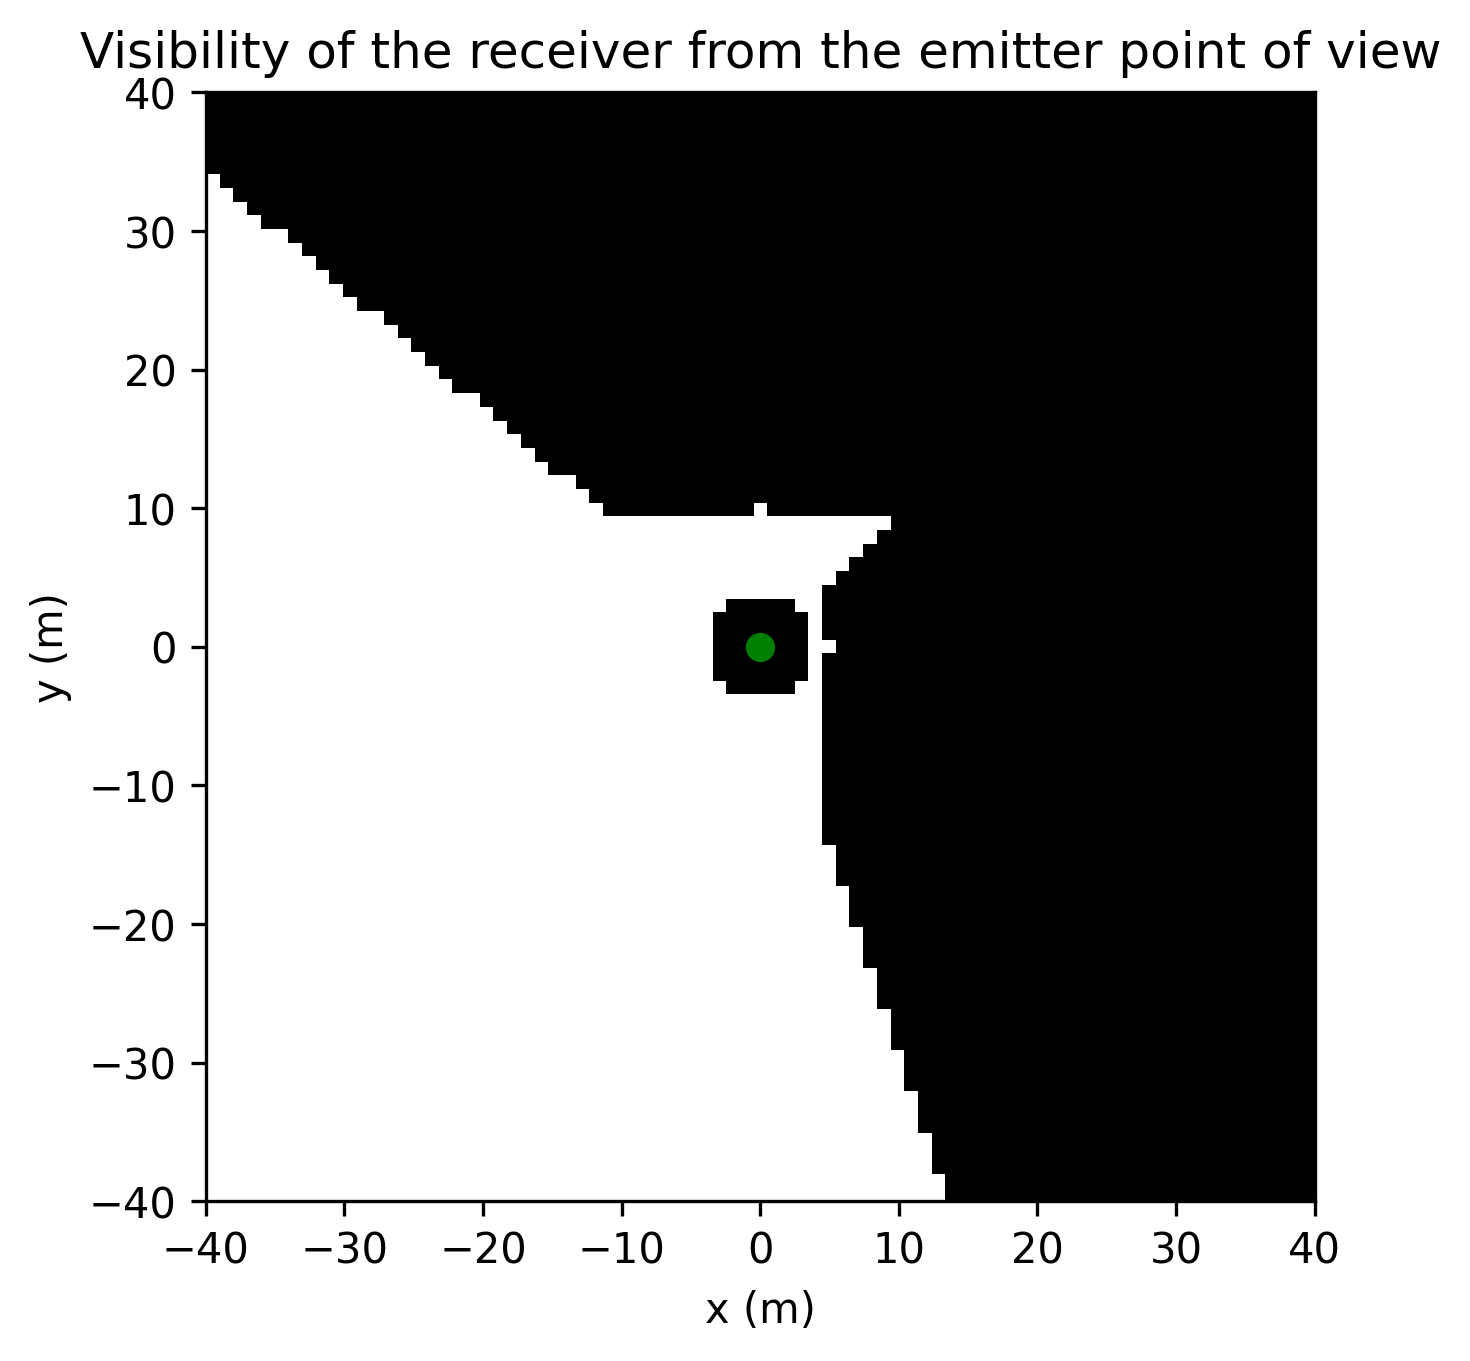

In [170]:
plt.figure(dpi=300)
plt.imshow(telecomPossible, cmap='gray', extent=[-40,40,-40,40])
plt.scatter(0,0,color='green')
plt.title("Visibility of the receiver from the emitter point of view")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.savefig('Visibility.png')
plt.show()

In [ ]:
### To create antennas from external USD use the following

stage = get_current_stage()
usd_path_antenna1 = f"omniverse://localhost/Users/ubuntu/antenna1.usdc"
antenna_path1 = prim_path + "/Antenna1"
usd_path_antenna2 = f"omniverse://localhost/Users/ubuntu/antenna2.usdc"
antenna_path2 = prim_path + "/Antenna2"
usd_path_body = f"omniverse://localhost/Users/ubuntu/body.usdc"
body_path = prim_path + "/Body"

prim_antenna1 = prims_utils.create_prim(prim_path=antenna_path1, usd_path=usd_path_antenna1, position = [5, -15, 15])

world.render()

prim_antenna2 = prims_utils.create_prim(prim_path=antenna_path2, usd_path=usd_path_antenna2, position = [-10, 10, 30])

world.render()

prim_body = prims_utils.create_prim(prim_path=body_path, usd_path=usd_path_body, position = [20, 0, 30])

world.render()